#                </>         Real Time Resistor Color Code Recognition </>

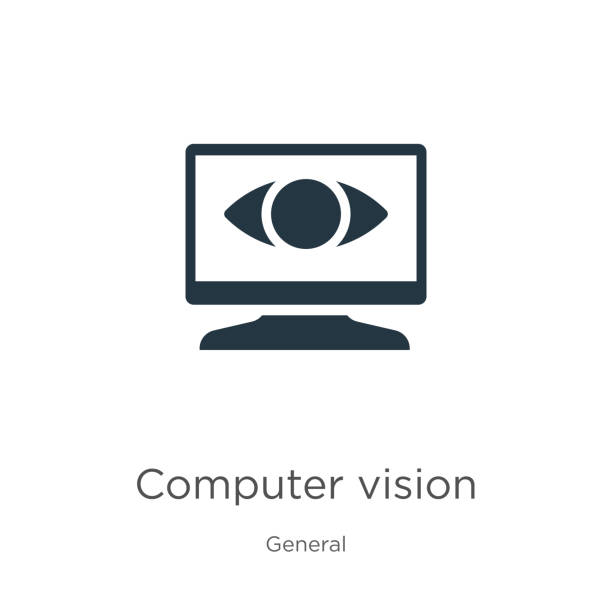

## Defining The Problem

***The goal of the project is to train a deep learning model that is able to recognize the color codes of resistor and write an algorithm that converts this color into numeric values.***


### Importing The Necessary Libaries

In [1]:
#import fastai
from fastai.vision.all import*
import os
import torch
import torchvision
from torchvision import transforms, datasets, utils

In [2]:
import PIL
import re
import os
import csv
import shutil, glob
import matplotlib.pyplot as plt

#### Reading The Datasets

In [3]:
resistor_csv = "./resistors.csv"
path = "./resistors/"
if os.path.isdir(path):
    print(f"found datasets {path}")
else:
     os.mkdir('resistors')   

found datasets ./resistors/


In [4]:
df = pd.read_csv(resistor_csv)
df.head()

,fname,label
0,000001.jpg,black black black orange black
1,000002.jpg,black black black red
2,000003.jpg,black black red gold
3,000004.jpg,black brown black purple yellow
4,000005.jpg,black brown black red brown


**The Data Preprocessing steps is as follows:<br><hr>
    1. The data is read into the code as a dataframe<br>
    2. The data is then pass into a data block<br>
    3. The individual images is cropped then resized<br>
    4. The size of each images after transformation is 3,224,224**

In [5]:
def get_y(y): return y['label'].split(' ')
def get_x(x): return path+x["fname"]


"""def splitter(df):

    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid
"""
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
               #splitter=splitter,
               get_x = get_x,
               get_y = get_y,
               item_tfms = RandomResizedCrop(224, min_scale=0.35))
dsets = db.datasets(df)
dls = db.dataloaders(df, bs=70)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
print(f"The classes of colors is as follows:\n {dsets.vocab}")

The classes of colors is as follows:
 ['black', 'blue', 'brown', 'gold', 'green', 'orange', 'purple', 'red', 'silver', 'white', 'yellow']


**Image shape and label with a batch size of 5**

In [7]:
train_loader,valid_loader = dls
data = iter(train_loader)
x,y = next(data)
x.shape, y.shape

(torch.Size([70, 3, 224, 224]), torch.Size([70, 11]))

**The Architecture of RestNet Model for recognizing Resistor color code**

**<p>RestNet</p>**

  **Image: 224 (height) * 224 (width) * 3 (channels)<hr>
  convolution1: Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))<br>
  ReLU<br>
  pooling: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)<hr>
  convolution: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))<br>
  ReLU<br>
  pooling: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)<hr>
  Flatten<br>
  fullyconected layer1: Linear(in_features=44944, out_features=120, bias=True)<hr>
  fullyconnected layer2: Linear(in_features=120, out_features=84, bias=True)<hr>
  fullyconected layer3: Linear(in_features=84, out_features=11, bias=True)<hr>**
    
                    output: 11 of 1 class

In [8]:
class RestNet(nn.Module):
    def __init__(self, ):
        super(RestNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = RestNet()
criterion = nn.BCEWithLogitsLoss()
#learning_rate = 0.1
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [27]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [9]:
#learn = Learner(dls, model, opt_func=SGD, loss_func=criterion, metrics=accuracy_multi)
#lr_min,lr_steep = learn.lr_find()
#learn.fit(10, 0.1)

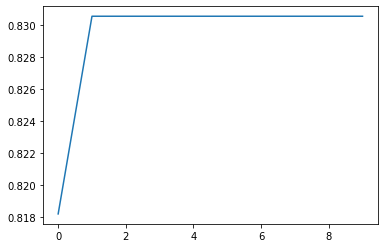

In [29]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [32]:
print(f'final accuracy is: {learn.recorder.values[-1][2]}')

final accuracy is: 0.8305784463882446


In [13]:
preds, targs = learn.get_preds()

In [14]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.6870)

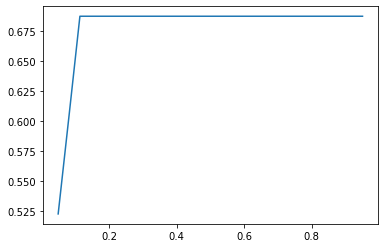

In [15]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In [11]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
accuracy_multi(preds, targs, thresh=0.8, sigmoid=False)

TensorMultiCategory(0.6870)

In [28]:
learn = Learner(dls, model, opt_func=SGD, loss_func=criterion, metrics=accuracy_multi)
learn.fit(20, 0.06)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.694856,0.663896,0.653926,00:17
1,0.651825,0.450755,0.827479,00:19
2,0.581265,0.394646,0.835744,00:19
3,0.538978,0.394063,0.835744,00:18
4,0.512833,0.396205,0.835744,00:18
5,0.495658,0.395669,0.835744,00:18
6,0.483402,0.386613,0.835744,00:19
7,0.474392,0.399460,0.835744,00:19
8,0.467474,0.394240,0.835744,00:19
9,0.461570,0.386157,0.835744,00:20


In [29]:
Path

pathlib.Path

In [30]:
learn.export()

In [10]:
path = Path()
path.ls(file_exts='.pkl')

(#3) [Path('export (2).pkl'),Path('export (3).pkl'),Path('export.pkl')]

In [11]:
learn_inf = load_learner(path/"export.pkl")

In [35]:
os.path.isfile('000067.jpg')

True

In [12]:
p=learn_inf.predict('000067.jpg')

In [13]:
p[1].sigmoid()

tensor([0.8279, 0.0656, 0.8267, 0.7361, 0.1174, 0.3254, 0.0222, 0.3540, 0.0657,
        0.0235, 0.1977])

In [14]:
(p[1].sigmoid()>0.5).float()

tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
dsets.vocab

['black', 'blue', 'brown', 'gold', 'green', 'orange', 'purple', 'red', 'silver', 'white', 'yellow']

In [ ]:
p.sigmoid()